In [1]:
try:
    from dm_control import suite
    env = suite.load('humanoid', 'run')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
    'Installition was wrong'
    )
else:
    from IPython.display import clear_output
    clear_output()
    del suite, env, pixels

In [2]:
# Imports

from dm_control import mujoco

In [3]:
# access to enums and mujoco library functions

from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

In [6]:
# PyMJCF

from dm_control import mjcf

In [7]:
# Composer high level imports

from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

In [8]:
# imports for composer tutorial example

from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

In [9]:
# control suite

from dm_control import suite

In [10]:
# Run through corridor example

from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

In [11]:
# Soccer
from dm_control.locomotion import soccer

In [12]:
# manipulation
from dm_control import manipulation

In [13]:
# other imports and helper functions
# general

import copy
import os
from IPython.display import clear_output
import numpy as np

In [14]:
# graphics-related
import matplotlib 
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

# using svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

In [15]:
# font sizes

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

In [16]:
# inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
    # skip video generation during tests, as it is quite expensive
    display_video = lambda *args, **kwarghs: None
else:
    def display_video(frames, framerate=30):
        height, width, _ = frames[0].shape
        dpi = 70
        orig_backend = matplotlib.get_backend()
        matplotlib.use('Agg')  # switch to headless 'Agg' to prevent figure rendering
        fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi)
        matplotlib.use(orig_backend)
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])
        im = ax.imshow(frames[0])
        
        def update(frame):
            im.set_data(frame)
            return [im]
        
        interval = 1000 / framerate
        anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, 
                                      interval=interval, blit=True, repeat=False)
        return HTML(anim.to_html5_video())
    
np.random.seed()
        

In [ ]:
# model definition, compilition and rendering

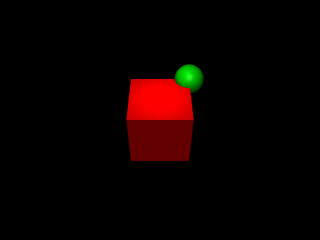

In [17]:
# simple model with two geoms and a light

static_model = """
<mujoco>
    <worldbody>
        <light name="top" pos="0 0 1" />
        <geom name = "red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
        <geom name = "green_sphere" pos=".2 .2 .2" size=".1" rgba = "0 1 0 1"/>
    </worldbody>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [18]:
# adding DOFs(degrees of freedom) by adding joints (hinge joint) to body and simulating


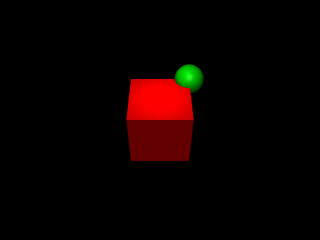

In [21]:
swinging_body = """
<mujoco>
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="box_and_sphere" euler="0 0 -30">
            <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2" />
            <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
            <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1" />
        </body>
    </worldbody>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(swinging_body)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
pixes = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

In [22]:
# making  a video

duration = 10 # seconds
framerate = 30 # Hz

frames = []
physics.reset()
while physics.data.time < duration:
    physics.step()
    
    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(scene_option = scene_option)
        frames.append(pixels)
display_video(frames, framerate)

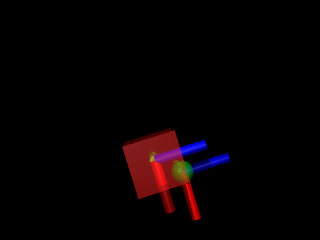

In [23]:
# additional rendering options 
# enable transparency and frames visualization

scene_option = mujoco.wrapper.core.MjvOption()
scene_option.frame = enums.mjtFrame.mjFRAME_GEOM
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

In [25]:
# making  a video for transparency and frames visualization

duration = 10 # seconds
framerate = 30 # Hz

frames = []
physics.reset()
while physics.data.time < duration:
    physics.step()
    
    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(scene_option = scene_option)
        frames.append(pixels)
display_video(frames, framerate)

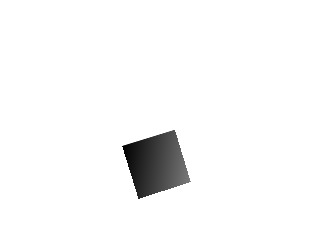

In [26]:
# Depth rendering

# depth is a float array, in meters
depth = physics.render(depth=True)
# shift nearest values to the origin
depth -= depth.min()
#scale by mean distance of near rays
depth /= 2*depth[depth <= 1].mean()
# scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)
PIL.Image.fromarray(pixels.astype(np.uint8))

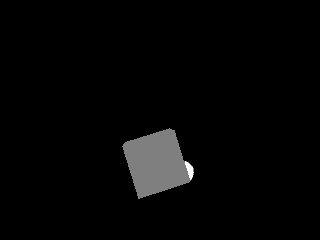

In [29]:
# Segmentation rendering

seg = physics.render(segmentation=True)

geom_ids = seg[:, :, 0]
# infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255 * geom_ids
PIL.Image.fromarray(pixels.astype(np.uint8))

In [30]:
# mujoco basics and named indexing

# mjModel

physics.model.geom_pos

array([[0. , 0. , 0. ],
       [0.2, 0.2, 0.2]])

In [31]:
help(type(physics.model).geom_pos)

Help on CachedProperty in module dm_control.mujoco.wrapper.util:

    local position offset rel. to body (ngeom x 3).



In [32]:
# The model.opt structure contains global quantities like
print('timestep = ', physics.model.opt.timestep)
print('gravity = ', physics.model.opt.gravity)

timestep =  0.002
gravity =  [ 0.    0.   -9.81]


In [33]:
# mjData
# mjData, encapsulated in physics.data, contains the state and quantities that depend on it. 
#The state is made up of time, generalized positions and generalised velocities. 
#These are respectively data.time, data.qpos and data.qvel.

print('time = ', physics.data.time, 'position = ', physics.data.qpos, 'velocity = ', physics.data.qvel )

time =  10.000000000000009 position =  [-1.41079857] velocity =  [-7.44532352]


In [34]:
print(physics.data.geom_xpos)

[[-0.03896141 -0.01043968 -0.44736694]
 [ 0.19528227  0.05232573 -0.69473389]]


In [35]:
# Named indexing

physics.named.model.geom_pos

FieldIndexer(geom_pos):
                 x         y         z         
0      red_box [ 0         0         0       ]
1 green_sphere [ 0.2       0.2       0.2     ]

In [36]:
physics.named.data.geom_xpos

FieldIndexer(geom_xpos):
                 x         y         z         
0      red_box [-0.039    -0.0104   -0.447   ]
1 green_sphere [ 0.195     0.0523   -0.695   ]

In [37]:
physics.named.data.geom_xpos['green_sphere', 'z']

-0.6947338895059701

In [38]:
physics.named.data.geom_xpos['red_box', 'z']

-0.4473669447529851

In [40]:
physics.named.data.qpos['swing']

array([-1.41079857])

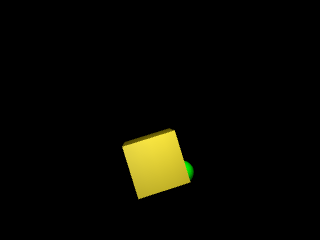

In [41]:
# changing colors using named indexing

random_rgb = np.random.rand(3)
physics.named.model.geom_rgba['red_box', :3] = random_rgb
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [46]:
#Setting the state with reset_context()

physics.named.data.qpos['swing'] = np.pi
print('withoud reset_context, spatial positions are not updated', 
     physics.named.data.geom_xpos['green_sphere', ['z']])

with physics.reset_context():
    physics.named.data.qpos['swing'] = np.pi-1.555648  
    
print('after reset_context, positions are updeted:', physics.named.data.geom_xpos['green_sphere', ['z']] )

withoud reset_context, spatial positions are not updated [-0.77167962]
after reset_context, positions are updeted: [0.35956142]


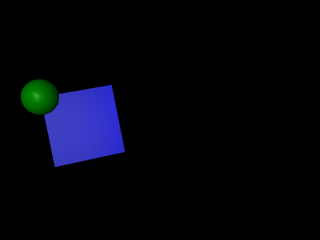

In [48]:
random_rgb = [0, 0, 1]
physics.named.model.geom_rgba['red_box', :3] = random_rgb
pixels = physics.render()
PIL.Image.fromarray(pixels)

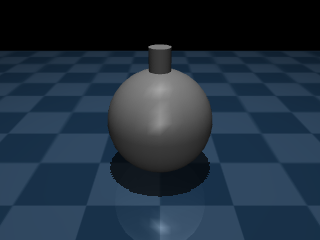

In [68]:
# Free bodies: the self-inverting "tippe-top"

tippe_top = """
<mujoco model="tippe top">
    <option integrator="RK4"/>
    <asset>
        <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
        rgb2=".2 .3 .4" width="300" height="300"/>
        <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2" />
    </asset>
    <worldbody>
        <geom size=".2 .2 .01" type="plane" material="grid"/>
        <light pos="0 0 .6"/>
        <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
        <body name="top" pos="0 0 .02">
            <freejoint/>
            <geom name="ball" type="sphere" size=".02"/>
            <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
            <geom name="ballast" type="box" size=".023 .023 0.005" pos="0 0 -.015" 
            contype="0" conaffinity="0" group="3"/>
        </body>    
    
    </worldbody>
    <keyframe>
        <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200"/>
    </keyframe>
</mujoco>
"""

physics = mujoco.Physics.from_xml_string(tippe_top)
PIL.Image.fromarray(physics.render(camera_id='closeup'))

In [69]:
print('positions = ', physics.data.qpos)
print('velocities = ', physics.data.qvel)

positions =  [0.   0.   0.02 1.   0.   0.   0.  ]
velocities =  [0. 0. 0. 0. 0. 0.]


In [71]:
# write video for the tipple-top

duration = 20
framerate = 60 

# Simulate and display video

frames = []
physics.reset(0) # reset to keyframe 0 (load a saved state)
while physics.data.time < duration:
    physics.step()
    if len(frames) < (physics.data.time) *  framerate:
        pixels = physics.render(camera_id='closeup')
        frames.append(pixels)
display_video(frames, framerate)

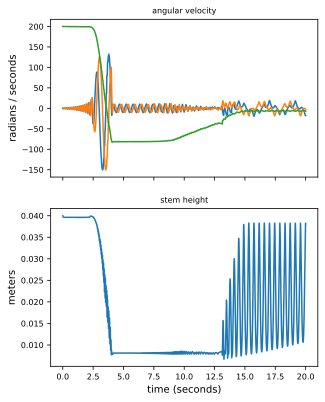

In [83]:
# Measuring values from physics.data

timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
physics.reset(0)
while physics.data.time < duration:
    physics.step()
    timevals.append(physics.data.time)
    angular_velocity.append(physics.data.qvel[3:6].copy())
    stem_height.append(physics.named.data.geom_xpos['stem', 'z'])
    
dpi = 100
width = 480
height = 640
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / seconds')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')